In [102]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [103]:
def readDataFromTspFile(fileName):
    with open(fileName, 'r') as file:
        lines = file.readlines()
        data = []
        trios = []
        for line in lines:
            trios = line.strip().split(';')
            coordinates = [int(trios[1]), int(trios[2])]
            data.append(coordinates)
        return data

ver_data = readDataFromTspFile('kroA100.txt')


In [104]:
def createDistanceMatrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]

  return np.array(outputMatrix)

print(createDistanceMatrix(ver_data))

[[   0 1693 2252 ...  783 1468 2643]
 [1693    0 1708 ... 1911 3156 1831]
 [2252 1708    0 ... 1786 3315  454]
 ...
 [ 783 1911 1786 ...    0 1535 2228]
 [1468 3156 3315 ... 1535    0 3760]
 [2643 1831  454 ... 2228 3760    0]]


In [105]:
def chooseNearestVertex(matrix, used_vertexes, node):
  return np.argmin([matrix[node][i] if i not in used_vertexes and i != node else float('inf') for i in range(0, len(matrix[node]))])


In [106]:
def calculateCycleLength(matrix, vertexes):
  length = 0
  for graph in vertexes:
    length += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])

#   print(length)
  return length

In [107]:
def greedyCycle(matrix, start_node):
    #Starting node 2
    start_node_2 = np.argmax(matrix[start_node])

    #Choosing nearest vertex for cycles
    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    #Creating cycles
    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    #Calculating cycles
    while len(cycles[0])+len(cycles[1]) != len(matrix):
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]

        z = np.inf
        x = np.inf
        c = np.inf

        for i in range(len(visited)):
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), visited[i])
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                if value < z:
                    z = value
                    x = j + 1
                    c = nearest

        if len(cycles[0]) <= len(cycles[1]):
            cycles[0] = np.insert(cycles[0], x, c)
        else:
            cycles[1] = np.insert(cycles[1], x, c)

    return cycles
                

     

In [110]:
def draw_plot(vertices, visited, length):
  for graph in visited:
    x = []
    y= []
    for idx in graph:
      x.append(vertices[idx][0])
      y.append(vertices[idx][1])
    plt.plot(x, y)
  plt.suptitle(f'score: {int(length)}')
  plt.show()

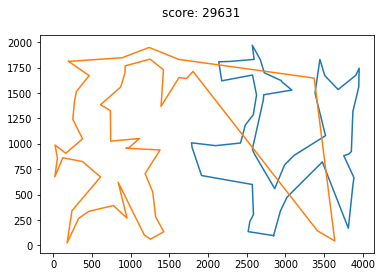

In [111]:
distance_matrix = createDistanceMatrix(ver_data)
start_node = random.randint(0, len(distance_matrix) - 1)
start_node = 1

vertexes = greedyCycle(distance_matrix, start_node)
length = calculateCycleLength(distance_matrix, vertexes)
draw_plot(ver_data, vertexes, length)
